# Mask-RCNN Tutorial

In [ ]:
# dowload the dataset from google drive 
! gdown --id 1CX3x0YmRmDQivhjfgB0kVzfXzVql7Axj

# dowload the basic functions
! gdown --id 1ZFtLIVLDyEX_AoK22peWdszOanvKxGyi
! gdown --id 1YF2GqFbLPdIsPCODZ4fA3mWaprPuNjuR

# unzip the dataset 
!unzip /content/stage1_train.zip

In [2]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import os
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.pytorch import ToTensorV2
from skimage import io, transform
import matplotlib.pyplot as plt
import random
import cv2
import pandas as pd

import data_preprocess as dp

In [3]:
## Access to the google drive
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [4]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## 1. Import data

In [5]:
#loading the datad
data_dir = '/content/stage1_train/'
data = dp.Nuclie_data(data_dir)
#data size
print(data.__len__())

670


In [23]:
img, target = data.__getitem__(5)

1


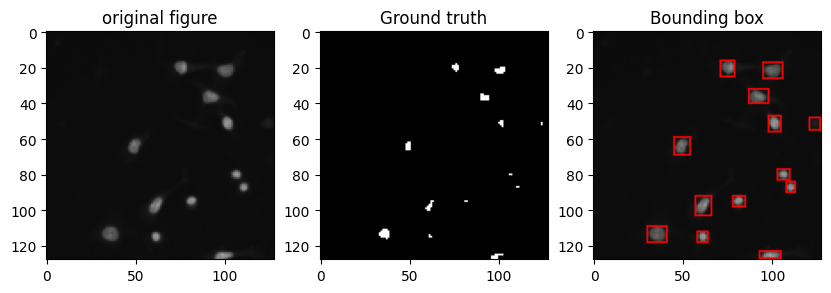

In [24]:
## showing the bounding box
plt.figure(figsize=(10,6))
plt.subplot(1,3,1)
plt.title('original figure')
plt.imshow(dp.image_convert(img))

plt.subplot(1,3,3)
plt.title('Bounding box')
plt.imshow(dp.plot_box(img, target['boxes']))

plt.subplot(1,3,2)
plt.title('Ground truth')
plt.imshow(dp.mask_convert(target['masks']), cmap='gray')

## 2. Model training 

In [7]:
import torchvision.models.segmentation
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [8]:
model=torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True) 

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [9]:
# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (nuclei) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one for class 2
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
model.to(device)# move model to the right device

In [ ]:
#switch to training mode 
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-5)
model.train()

In [12]:
##### parameters setting #####
train_set = 580
batch_sizes = 1
iteration = 21
outdir = "/content/MyDrive/MyDrive/trained_model/"
##############################

loss_epoch = []
for i in range(iteration):       
    
    #how many batches used in each iteration 
    for b in range(batch_sizes):
        images = []
        targets = []
        idx=random.randint(0,train_set-1)
        image_, target_ = data.__getitem__(idx)
        images.append(image_)
        targets.append(target_)

    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
    print(f"start iteration {i}")
    optimizer.zero_grad()
    loss_dict = model(images, targets)

    losses = sum(loss for loss in loss_dict.values())
    losses.backward()
    optimizer.step()
    print(i,'loss:', losses.item())
    loss_epoch.append(losses.item())
    #save model for every 100 iteration 
    if i%200==0:
       torch.save(model.state_dict(), os.path.join(outdir,str(i)+"_augmentation_batch" + str(batch_sizes)+ ".torch"))
    
df = pd.DataFrame (loss_epoch, columns = ['iteration'])
df.to_csv(os.path.join(outdir,str(i)+"_augmentation_batch" + str(batch_sizes)+".loss.csv"), sep='\t')

1
start iteration 0
0 loss: 3.448223114013672
1
start iteration 1
1 loss: 2.2991063594818115
0
start iteration 2
2 loss: 4.821704864501953
1
start iteration 3
3 loss: 2.987880229949951
1
start iteration 4
4 loss: 2.584888458251953
0
start iteration 5
5 loss: 7.708706855773926
0
start iteration 6
6 loss: 1.4201292991638184
1
start iteration 7
7 loss: 1.7909717559814453
0
start iteration 8
8 loss: 1.3591797351837158
0
start iteration 9
9 loss: 3.4724748134613037
1
start iteration 10
10 loss: 1.7231659889221191
0
start iteration 11
11 loss: 2.278752565383911
1
start iteration 12
12 loss: -inf
1
start iteration 13
13 loss: 2.0569276809692383
0
start iteration 14
14 loss: 1.9989476203918457
0
start iteration 15
15 loss: 0.6381665468215942
1
start iteration 16
16 loss: -4.634037816927519e+32
0
start iteration 17
17 loss: 0.6346272230148315
0
start iteration 18
18 loss: 1.9734795093536377
1
start iteration 19
19 loss: 1.605878233909607
1
start iteration 20
20 loss: 1.7825121879577637


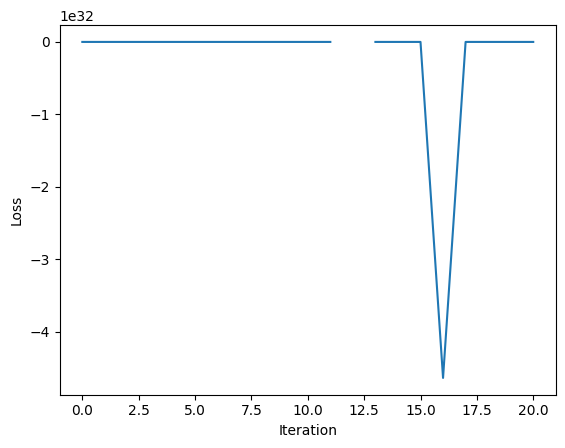

In [13]:
# Plot loss
plt.plot(list(range(len(loss_epoch))), loss_epoch)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

## Evaluation 

In [14]:
import torchvision.models.segmentation
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [15]:
#load the pre-trained model 
model=torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True) 
in_features = model.roi_heads.box_predictor.cls_score.in_features 
model.roi_heads.box_predictor=FastRCNNPredictor(in_features,num_classes=2)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#load your model and set the model to evaluation state
model.load_state_dict(torch.load("/content/MyDrive/MyDrive/trained_model/800_augmentation_batch4.torch"))
model.eval()

In [ ]:
model.to(device)# move model to the right device

In [18]:
## create test dataset 
data_dir = '/content/stage1_train/'
data_test = dp.individual_mask_data(data_dir)

0


In [21]:
## caculate the overall accuracy
acc = dp.pixel_accuracy(data_test, model, 640, device)
print("Accuracy =", acc)

Accuracy = 0.8896484375


/content/data_preprocess.py:188: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  masks = torch.as_tensor(masks, dtype=torch.uint8)


In [22]:
## caculate the IoU matrix
evaluator = dp.evaluate_IoU(data_test, model, range(581, 670), device)

creating index...
index created!
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.551
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.966
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.655
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.551
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.020
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.180
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.613
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.613
 Average Recall     (AR) @[ IoU=0.50:0.95 | ar

In [23]:
## visualization 
imag, target = data.__getitem__(620)
img = []
img.append(imag)
img = list(image.to(device) for image in img)

# testing the model 
with torch.no_grad():
    pred = model(img)

1


In [24]:
## get predicted boxes when score > 0.5
pred_box = dp.get_predicted_box(pred, cutoff = 0.5)
p_0 = dp.plot_box(imag, pred_box)

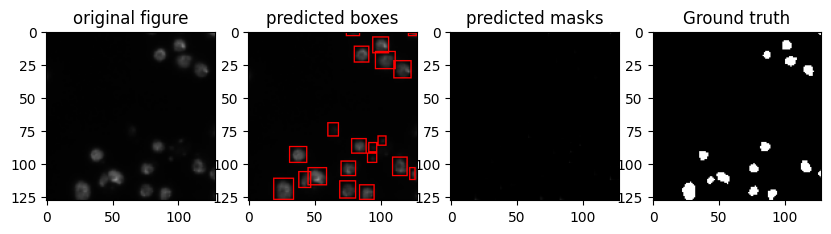

In [26]:
plt.figure(figsize=(10,6))
plt.subplot(1,4,1)
plt.title('original figure')
plt.imshow(dp.image_convert(imag))

plt.subplot(1,4,2)
plt.title('predicted boxes')
plt.imshow(p_0)

plt.subplot(1,4,3)
plt.title('predicted masks')
plt.imshow(dp.get_predicted_masks(pred, cutoff = 0.5), cmap='gray')

plt.subplot(1,4,4)
plt.title('Ground truth')
plt.imshow(dp.mask_convert(target['masks']), cmap='gray')